## Introduction

The Emergency and Security Coordinating Centre (CECOES 1-1-2) performs the coordination of different resources available in the Canary Islands relating to emergencies, among others, the Canary Islands Emergency Service (SUC), Emergency and Rescue Group (GES), the different police forces (Local Police, National Police and Civil Guard), the Fire Service and the Domestic Violence Service. The next chart shows the different coordinated services.

<img src="cecoes.png" alt="CECOES 1-1-2" style="width:604px;height:328px;">

The prediction of incidents represents an important issue for emergency services organisations in order to accurately forecast the daily number of alerts by municipality, explain seasonal patterns in the frequency of incidents or even detect unusual events in historical records.

## Forecasting the Number of Incidents using Time Series Models

TBATS is an acronym for the key features of the time series model proposed by [De Livera, 2010](#de_livera1)), that is, an exponential smoothing method with Trigonometric seasonal + Box-Cox transformation + ARMA model for residuals + Trend and Seasonal components


\begin{aligned}\label{eq:tbats}
&y_t^{(\lambda)} = l_{t-1} + \varphi b_{t-1} + \sum_{i=1}^T s_{t-m_i}^{(i)} + \eta_t \\ 
&l_t = l_{t-1} + \varphi b_{t-1} + \alpha \eta_t \\ 
&b_t = (1-\varphi)b + \varphi b_{t-1} + \beta \eta_t \\ 
&s_{t}^{(i)} = s_{t-m_i}^{(i)} + \gamma_i \eta_t\\
&\phi(B)\nabla^d \eta_t=\theta(B) z_t
\end{aligned}

where $y_t^{\left(\lambda\right)}$ represents the Box-Cox transformed observation with  parameter $\lambda$ at time $t$, that is 

\begin{aligned}\label{eq:boxcox}
&y_t^{(\lambda)} = \left\{
\begin{array}{ll}
      \frac{y_t^\lambda-1}{\lambda}, & \lambda \neq 0, \\
      \log{y_t}, & \lambda = 0, 
\end{array} 
\right.
\end{aligned}

and $m_1,...,m_T$ denote the seasonal periods, $l_t$ is the local level in period $t$, $b$ and $b_t$ are the long and short-run trends in period $t$, respectively, and $\varphi$ is the parameter of the damped trend. Denoting $T$ as the total number of time values, the $i$th seasonal components at time $t$ in the model, for $i=1,...,T$, are given by $s_t^{(i)}=\sum_{j=1}^{K_i}s_{j,t}^{(i)}$, where

\begin{aligned}\label{eq:tbats}
&s_{j,t}^{(i)} = s_{j,t-1}^{(i)}\cos\left(\frac{2\pi j}{m_i}\right) + s_{j,t-1}^{*(i)}\sin\left(\frac{2\pi j}{m_i}\right)+ \delta_1^{(i)} \eta_t  \\
&s_{j,t}^{*(i)} = -s_{j,t-1}\sin\left(\frac{2\pi j}{m_i}\right) + s_{j,t-1}^{*(i)}\cos\left(\frac{2\pi j}{m_i}\right)+ \delta_2^{(i)} \eta_t  \\
\end{aligned}

with $K_i$ the number of harmonics in the $i$th seasonal component. As in the previous model, $\eta_t$ and $z_t$ are a non-seasonal ARMA($p$,$q$) process and a Gaussian white noise process with zero mean and constant variance $\sigma^2$, respectively. The smoothing parameters are given by $\alpha, \beta, \gamma, \delta_1^{\left(i\right)}$ and $\delta_2^{\left(i\right)}$. 

### Illustrative example

We are going to fit the daily number of incidents from January, 2013 to January, 2015, in the municipality of La Orotava (in Tenerife)

In [17]:
#install.packages("dplyr","forecast","ggplot2","zoo")
require(dplyr)
require(forecast)
require(ggplot2)
require(zoo)
require(scales)

Loading required package: scales


In [2]:
load("serie1_orotava.RData")
load("forecast_objects.RData")

In [7]:
serie1<-left_join(serie1,day_df[,c("date","fest")],by="date") 
serie5<-subset(serie1, date >= strftime('2010-01-01', format = '%Y-%m-%d') & date <= strftime('2015-01-31', format = '%Y-%m-%d'))
serie5 <- ts(serie5$N, frequency=365.25, start=c(2010,1,1))
serie5_days<-day_df[day_df$date>="2010-01-01" & day_df$date<="2015-01-31",]
serie5_days$time<-round(time(serie5),3)

serie5_hist<-window(serie5, 
                    start=min(serie5_days$time[serie5_days$date>="2010-01-01"]),
                    end=max(serie5_days$time[serie5_days$date<="2014-12-31"]) )

In [10]:
serie5tbats <- tbats(serie5_hist,seasonal.periods = c(7,30.4,365.25), use.parallel=TRUE, num.cores = 2)

In [25]:
fc <- forecast(serie5tbats, h=30)
pd<-funggcast(serie5,fc,serie5_days) 
pd<-pd[pd$date>="2014-10-28",]

Warning message:
"Removed 30 rows containing missing values (geom_path)."Warning message:
"Removed 65 rows containing missing values (geom_path)."

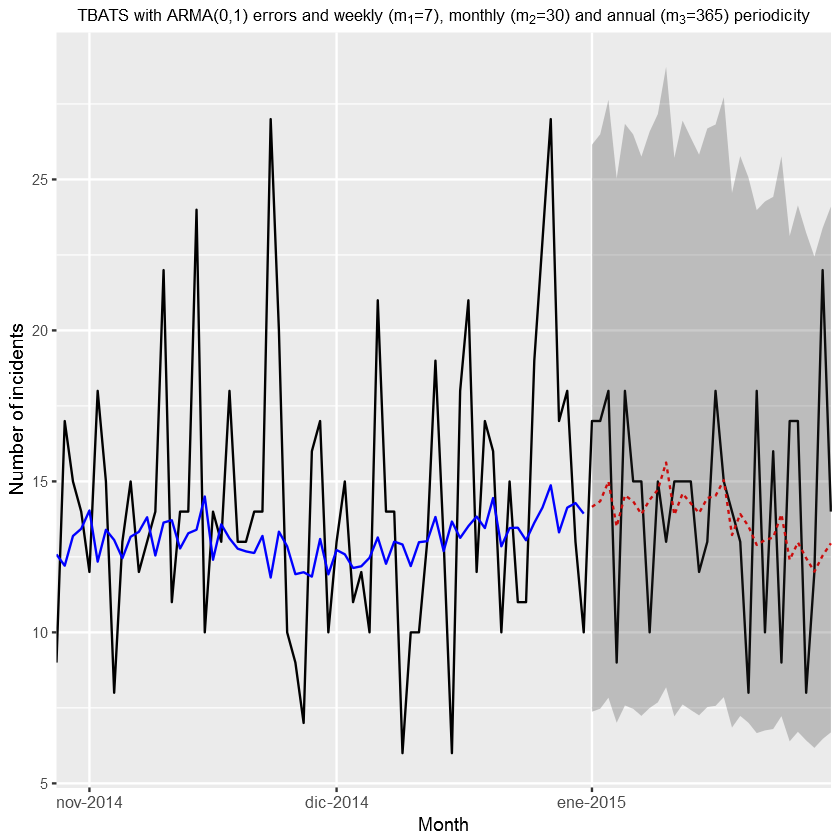

In [26]:
tbats_chart<-ggplot(data=pd,aes(x=date,y=observed)) +
     geom_line(col='black') +
     geom_line(aes(y=fitted),col='blue') +
     geom_line(aes(y=forecast),col='red',lty=2)+
     geom_ribbon(aes(ymin=lo95,ymax=hi95),alpha=.25)+
     scale_x_date(name='Month',date_breaks='1 month',date_minor_breaks='1 month',labels=date_format("%b-%Y"),expand=c(0,0))+
     scale_y_continuous(name='Number of incidents')+
     theme(axis.text.x=element_text(size=10),plot.title=element_text(hjust = 0.5),plot.subtitle=element_text(hjust = 0.5)) + 
     labs(subtitle=bquote('TBATS with ARMA('*.(serie5tbats$p)*','*.(serie5tbats$q)*') errors and weekly ('*m[1]*'=7), monthly ('*m[2]*'=30) and annual ('*m[3]*'=365) periodicity' ))

tbats_chart

## References

<a id='de_livera1'></a> De Livera, A. M. (2010) [“Automatic forecasting with a modified exponential smoothing state space framework.”](https://ideas.repec.org/p/msh/ebswps/2010-10.html) Monash Econometrics and Business Statistics Working Papers 10, no. 10.

<a id='de_livera2'></a> De Livera, A. M., Hyndman, R. J. and Snyder, R. D. (2011) [“Forecasting time series with complex seasonal patterns using exponential smoothing.”](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771) Journal of the American Statistical Association 106, no. 496, pp. 1513-1527.